In [ ]:
!pip install riskfolio-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.8/314.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
import riskfolio as rp
import yfinance as yf
warnings.filterwarnings("ignore")

In [ ]:
def get_data(start, end, assets):
    pd.options.display.float_format = '{:.4%}'.format

    data = yf.download(assets, start = start, end = end)
    data = data.loc[:,('Close', slice(None))]
    data.columns = assets
    return data

def get_returns(assets, data):
    Y = data[assets].pct_change().dropna()
    return Y

In [ ]:
import riskfolio as rp

def generate_dendrogram_plot(returns , codependence ='pearson', linkage='average', k=None, max_k=10, leaf_order=True, ax=None):
    ax = rp.plot_dendrogram(returns=returns,
                        codependence=codependence,
                        linkage=linkage,
                        k=k,
                        max_k=max_k,
                        leaf_order=leaf_order,
                        ax=ax)


In [ ]:
def get_weights_and_port(returns, model='HRP', codependence='pearson', rm='UCI_Rel', rf=0, linkage='average', max_k=10, leaf_order=True):
    # Building the portfolio object
    port = rp.HCPortfolio(returns=returns)

    # Estimate optimal portfolio
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)
    return w,port


In [ ]:
def display_hrp_pie_visualization(weights):
    ax = rp.plot_pie(w=weights,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

In [ ]:
def visualize_asset_risk(returns, weight, rm='MV'):
    mu = returns.mean()
    cov = returns.cov() # Covariance matrix
    returns = returns # Returns of the assets

    ax = rp.plot_risk_con(w=weight,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

In [ ]:
# Risk Measures available:
#
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.

def calculate_risk_metrics(port, model='HRP', rf=0, linkage='average', max_k=10, leaf_order=True):
    w_s = pd.DataFrame([])

    rms = ['vol', 'MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'VaR','CVaR', 'EVaR', 'WR', 'MDD', 'ADD',
       'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel', 'ADD_Rel',
       'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']

    for i in rms:
        w = port.optimization(model=model,
                              rm=i,
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)

        w_s = pd.concat([w_s, w], axis=1)

    w_s.columns = rms

    return w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')


In [ ]:
def avg_weight_all_risk(port, model='HRP', rf=0, linkage='average', max_k=10, leaf_order=True):

    rms = ['vol', 'MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'VaR','CVaR', 'EVaR', 'WR', 'MDD', 'ADD',
       'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel', 'ADD_Rel',
       'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']
    w  = 0
    for i in rms:
        wm = port.optimization(model=model,
                              rm=i,
                              rf=rf,
                              linkage=linkage,
                              max_k=max_k,
                              leaf_order=leaf_order)
        w += wm
    return (w/len(rms))

In [ ]:
def calculate_portfolio_value(w, data, initial_amount=1000000):
    # Ensure weights are in float format
    weight = w['weights']
# Calculate the number of stocks to buy for each asset
    stocks =( weight*initial_amount / data.iloc[0])
# stocks = stocks.astype(int)
    capital_left = initial_amount - (stocks * data.iloc[0]).sum()
    portfolio_value = (stocks * data.iloc[-1]).sum() + capital_left

#     print(f'''The value of the portfolio is: {portfolio_value:.2f}
# Returns from the given portfolio management are {(portfolio_value - initial_amount)*100/initial_amount:.2f}''')
    return portfolio_value

## EXAMPLE OF HOW IT WORKS (INSIGHTS INTO PROCESS).

In [ ]:
assets = ["ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS",
          "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS",
          "BEL.NS", "BPCL.NS", "BHARTIARTL.NS", "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS",
          "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
          "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS",
          "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS",
          "NESTLEIND.NS", "NTPC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS",
          "SHRIRAMFIN.NS", "SBIN.NS", "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS",
          "TATASTEEL.NS", "TECHM.NS", "TITAN.NS", "TRENT.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]

assets.sort()
data = get_data("2023-01-01", "2024-01-01", assets)
Y = get_returns(assets, data)
w, port = get_weights_and_port(Y, model="HRP", rm='UCI_Rel')

[*********************100%***********************]  48 of 48 completed


## Clustering based on various correlation within stocks

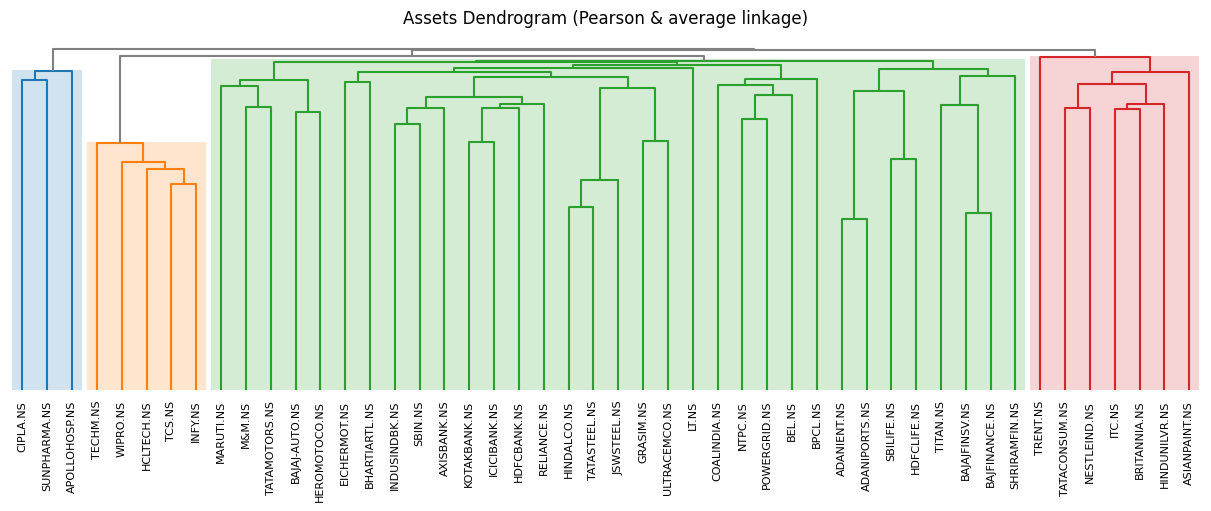

In [ ]:
generate_dendrogram_plot(Y)

# Distribution of Risk Within Each Cluster

## Overview
The risk distribution within each cluster is based on a selected **risk parameter**. This can be achieved using either of the following models:

1. **HRP (Hierarchical Risk Parity)**
2. **HERC (Hierarchical Equal Risk Contribution)**

There are **20 types of risk management parameters** available for risk distribution and weight assignment.

---

## Available Risk Measures

| Code       | Description |
|------------|-----------------------------------------------------------|
| **vol**    | Standard Deviation |
| **MV**     | Variance |
| **MAD**    | Mean Absolute Deviation |
| **MSV**    | Semi Standard Deviation |
| **FLPM**   | First Lower Partial Moment (Omega Ratio) |
| **SLPM**   | Second Lower Partial Moment (Sortino Ratio) |
| **VaR**    | Value at Risk |
| **CVaR**   | Conditional Value at Risk |
| **EVaR**   | Entropic Value at Risk |
| **WR**     | Worst Realization (Minimax) |
| **MDD**    | Maximum Drawdown (Calmar Ratio, uncompounded) |
| **ADD**    | Average Drawdown (uncompounded) |
| **DaR**    | Drawdown at Risk (uncompounded) |
| **CDaR**   | Conditional Drawdown at Risk (uncompounded) |
| **EDaR**   | Entropic Drawdown at Risk (uncompounded) |
| **UCI**    | Ulcer Index (uncompounded) |
| **MDD_Rel** | Maximum Drawdown (Calmar Ratio, compounded) |
| **ADD_Rel** | Average Drawdown (compounded) |
| **DaR_Rel** | Drawdown at Risk (compounded) |
| **CDaR_Rel** | Conditional Drawdown at Risk (compounded) |
| **EDaR_Rel** | Entropic Drawdown at Risk (compounded) |
| **UCI_Rel** | Ulcer Index (compounded) |

---

## Approach

```python
# List of assets
assets = [
    "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS",
    "BEL.NS", "BPCL.NS", "BHARTIARTL.NS", "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
    "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS",
    "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS",
    "NESTLEIND.NS", "NTPC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS",
    "SHRIRAMFIN.NS", "SBIN.NS", "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS",
    "TATASTEEL.NS", "TECHM.NS", "TITAN.NS", "TRENT.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]

# Sort assets alphabetically
assets.sort()

# Fetch historical data
data = get_data("start_Date", "end_date", assets)

# Compute daily returns
Y = get_returns(assets, data)  # Provides daily percentage change in closing price

# Distribute risk and assign weights using the HRP model and a selected risk management method
w, port = get_weights_and_port(Y, model="HRP", rm='UCI_Rel')


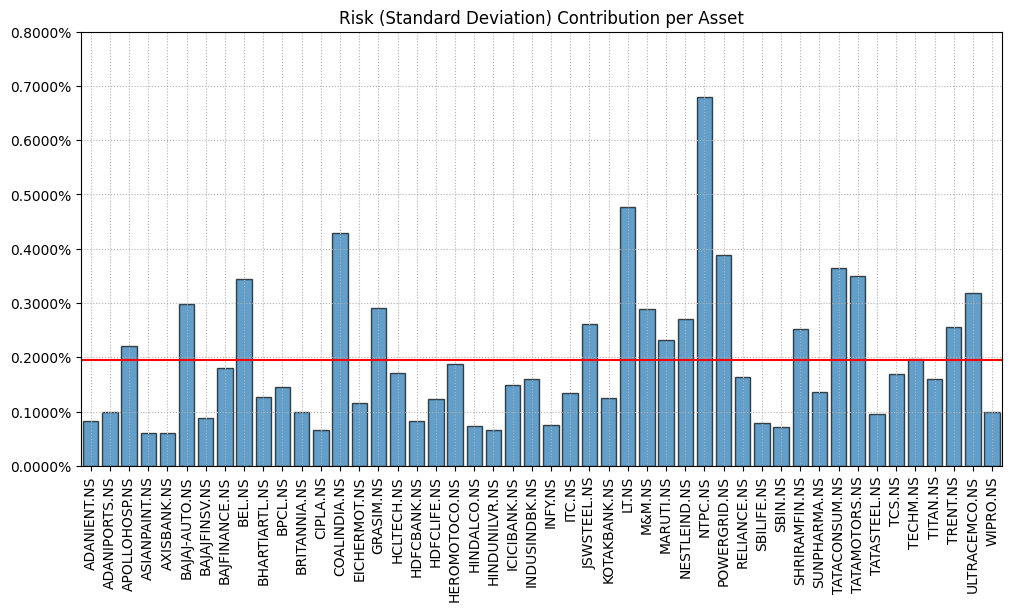

In [ ]:
visualize_asset_risk(Y, w)

#### Within cluster distribution of weights on the basis of mentioned risk management parameter. The model uses Hirerchial risk parity in order to distribute risk within the clusters and then according to this risk themodel assigns weight to each asset withing the cluster and then normalizes the weights in order to keep the sum = 1.

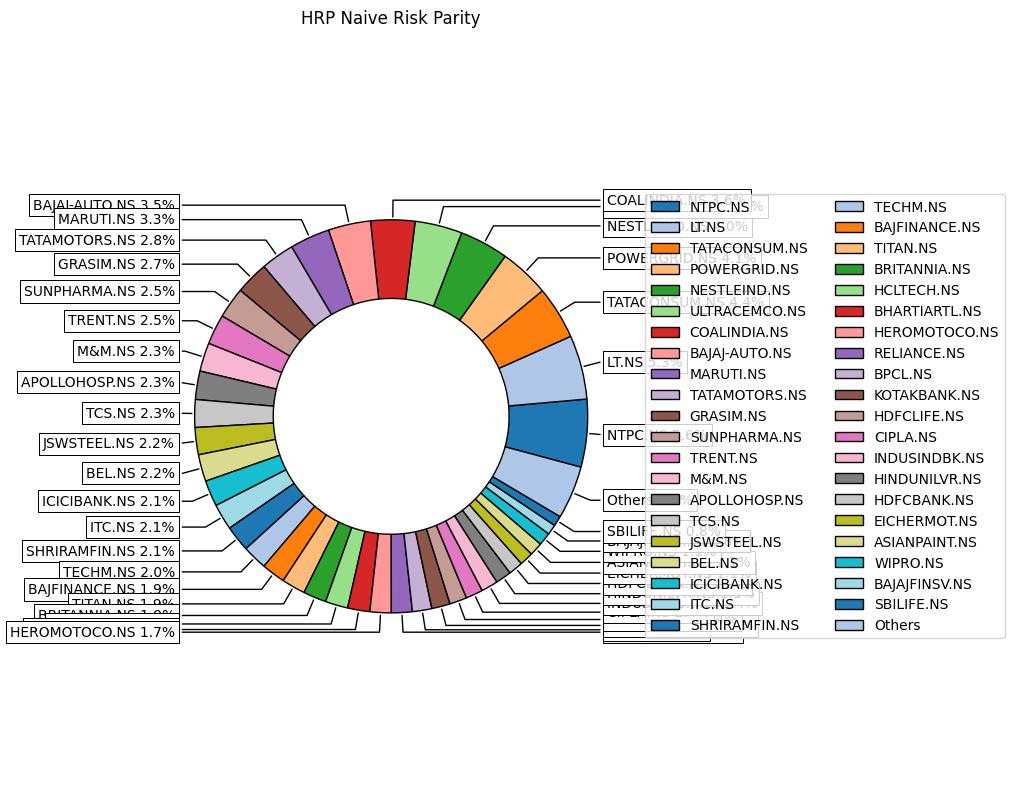

In [ ]:
display_hrp_pie_visualization(w)

## Below is table of values of different type of risk measure of each input asset

In [ ]:
calculate_risk_metrics(port)

,vol,MV,MAD,MSV,FLPM,SLPM,VaR,CVaR,EVaR,WR,MDD,ADD,DaR,CDaR,EDaR,UCI,MDD_Rel,ADD_Rel,DaR_Rel,CDaR_Rel,EDaR_Rel,UCI_Rel
ADANIENT.NS,0.78%,0.21%,1.02%,0.75%,0.84%,0.67%,1.03%,0.60%,0.50%,0.50%,0.38%,0.30%,0.28%,0.30%,0.35%,0.32%,0.45%,0.26%,0.29%,0.34%,0.40%,0.31%
ADANIPORTS.NS,0.77%,0.44%,0.95%,0.69%,0.86%,0.64%,1.03%,0.60%,0.40%,0.37%,0.41%,0.54%,0.37%,0.38%,0.40%,0.49%,0.39%,0.52%,0.34%,0.35%,0.38%,0.49%
APOLLOHOSP.NS,1.87%,2.01%,1.78%,2.00%,1.78%,2.03%,1.90%,2.29%,2.77%,2.85%,2.54%,2.24%,2.57%,2.55%,2.58%,2.38%,2.51%,2.19%,2.56%,2.56%,2.57%,2.33%
ASIANPAINT.NS,2.25%,3.00%,2.24%,1.99%,2.05%,1.88%,2.06%,1.65%,1.66%,1.69%,1.29%,0.94%,1.49%,1.34%,1.29%,1.08%,1.34%,0.95%,1.50%,1.37%,1.32%,1.09%
AXISBANK.NS,1.78%,1.83%,1.78%,1.78%,1.62%,1.67%,1.84%,1.64%,1.49%,1.46%,0.93%,0.71%,0.70%,0.77%,0.82%,0.73%,0.98%,0.74%,0.77%,0.83%,0.87%,0.76%
BAJAJ-AUTO.NS,1.63%,1.54%,1.71%,1.72%,2.26%,2.01%,2.04%,1.95%,1.51%,1.26%,2.58%,4.07%,3.13%,2.75%,2.76%,3.56%,2.53%,3.97%,3.11%,2.74%,2.73%,3.49%
BAJAJFINSV.NS,1.73%,1.75%,1.80%,1.65%,1.66%,1.57%,1.38%,1.38%,1.57%,1.56%,1.05%,0.81%,0.99%,1.06%,1.04%,0.83%,1.09%,0.83%,1.01%,1.08%,1.06%,0.84%
BAJFINANCE.NS,2.64%,2.09%,2.66%,2.67%,2.55%,2.62%,2.41%,2.58%,2.42%,2.38%,2.57%,1.81%,2.47%,2.61%,2.57%,1.94%,2.59%,1.82%,2.52%,2.61%,2.58%,1.95%
BEL.NS,1.31%,1.13%,1.32%,1.23%,1.47%,1.26%,1.21%,1.04%,1.04%,0.96%,1.97%,2.55%,1.90%,1.99%,2.01%,2.26%,1.78%,2.53%,1.71%,1.80%,1.83%,2.22%
BHARTIARTL.NS,2.23%,2.87%,2.18%,2.29%,2.19%,2.29%,2.47%,2.36%,2.10%,2.09%,1.64%,1.80%,1.65%,1.57%,1.61%,1.84%,1.65%,1.78%,1.66%,1.58%,1.61%,1.82%


## Date Generation Method

### Below you can see the code for generating periods after which we will dynamically switch the weights.

You can see these three lines in the code below:

```python
start_date_test = "2022-01-01"  # First element of start_dates_test
lookback_months = 6  # Lookback period
periods = 7  # Number of periods
```

1) **Start date** - The date from which we want to backtest our model.
2) **Lookback months** - It will take the previous six months of data from a given date, feed that data to the model to generate the weights, and then use these weights for the next six months.
3) **Periods** - The number of periods we want. For example:
   - If `start_date = "2022-01-01"` and `periods = 4`, the four periods will be:
     - (2022-01-01 to 2022-07-01)
     - (2022-07-01 to 2023-01-01)
     - (2023-01-01 to 2023-07-01)
     - (2023-07-01 to 2024-01-01)
   
   - If `periods = 7`, the periods will be:
     - (2022-01-01 to 2022-07-01)
     - (2022-07-01 to 2023-01-01)
     - (2023-01-01 to 2023-07-01)
     - (2023-07-01 to 2024-01-01)
     - (2024-01-01 to 2024-07-01)
     - (2024-07-01 to 2025-01-01)
     - (2025-01-01 to 2025-07-01)


In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def generate_date_ranges(start_date_test, lookback_months, periods):
    start_dates_test = []
    end_dates_test = []
    start_dates_train = []
    end_dates_train = []

    # Generate test dates
    for i in range(periods):
        start_date = datetime.strptime(start_date_test, "%Y-%m-%d") + relativedelta(months=6 * i)
        end_date = start_date + relativedelta(months=6)
        start_dates_test.append(start_date.strftime("%Y-%m-%d"))
        end_dates_test.append(end_date.strftime("%Y-%m-%d"))

    # Generate train dates with the lookback period
    for start_test, end_test in zip(start_dates_test, end_dates_test):
        start_train = datetime.strptime(start_test, "%Y-%m-%d") - relativedelta(months=lookback_months)
        end_train = datetime.strptime(start_test, "%Y-%m-%d")
        start_dates_train.append(start_train.strftime("%Y-%m-%d"))
        end_dates_train.append(end_train.strftime("%Y-%m-%d"))

    return start_dates_train, end_dates_train, start_dates_test, end_dates_test

# Example usage
start_date_test = "2017-01-01"                    # First element of start_dates_test
lookback_months = 6                               # Lookback period
periods = 16                                    # Number of periods

start_dates_train, end_dates_train, start_dates_test, end_dates_test = generate_date_ranges(
    start_date_test, lookback_months, periods
)


print("Start Dates Test:", start_dates_test)
print("End Dates Test:", end_dates_test)


Start Dates Test: ['2017-01-01', '2017-07-01', '2018-01-01', '2018-07-01', '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', '2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01', '2023-01-01', '2023-07-01', '2024-01-01', '2024-07-01']
End Dates Test: ['2017-07-01', '2018-01-01', '2018-07-01', '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', '2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01', '2023-01-01', '2023-07-01', '2024-01-01', '2024-07-01', '2025-01-01']


In [ ]:


train_date = pd.DataFrame({
    'start_dates': start_dates_train,
    'end_dates': end_dates_train
})

test_date = pd.DataFrame({
    'start_dates': start_dates_test,
    'end_dates': end_dates_test
}
)

In [ ]:
def dynamic_weight_switching(train_date, test_date, assets,model, rm):
    assets.sort()
    initial_value = 1000000
    portfolio_value = pd.Series()
    for i in range(len(train_date)):
        data_train = get_data(train_date['start_dates'][i], train_date['end_dates'][i], assets)
        Y = get_returns(assets, data_train)
        w, port = get_weights_and_port(Y, model=model, rm=rm)              ## HRP or HERC
        data_test = get_data(test_date['start_dates'][i], test_date['end_dates'][i], assets)
        Y_test = get_returns(assets, data_test)
        portfolio_returns = (Y_test * w['weights']).sum(axis=1)
        portfolio = (1 + portfolio_returns).cumprod() * initial_value
        initial_value = calculate_portfolio_value(w, data_test, initial_amount=initial_value)
        portfolio_value = pd.concat([portfolio_value, portfolio])
    total_data = get_data(test_date['start_dates'][0], test_date['end_dates'][i], assets)
    total_data['portfolio'] = portfolio_value
    total_data['portfolio'] = total_data['portfolio'].fillna(method='ffill')
    total_data['portfolio'][0] = 1000000
    nifty = yf.download('^NSEI', start = test_date['start_dates'][0], end = test_date['end_dates'][i])
    initial_amount = 1000000
    nifty['portfolio'] = initial_amount * (nifty['Close'] / nifty['Close'].iloc[0])
    return total_data,nifty


### Chnges assets according to yourself in which we want to invest.
### Initial capital has benn taken as 1000000

## Here you can simply change assets according to you.
##In the model section you can change the models between - HRP and HERC
##For risk management us can use any present in above table

In [ ]:
assets = ["ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS",
          "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS",
          "BEL.NS", "BPCL.NS", "BHARTIARTL.NS", "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS",
          "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS",
          "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS",
          "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS",
          "NESTLEIND.NS", "NTPC.NS", "POWERGRID.NS", "RELIANCE.NS",
           "SBIN.NS", "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS",
          "TATASTEEL.NS", "TECHM.NS", "TITAN.NS", "TRENT.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]
total_data,nifty = dynamic_weight_switching(train_date, test_date, assets, model = "HERC", rm='UCI_Rel')


[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*********************100%***********************]  45 of 45 completed
[*****

## Comparision of Model performance vs NIFTY performance

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Ensure your 'Date' column is a datetime object
total_data['Date'] = pd.to_datetime(total_data.index)

# Create a new column for three-month periods
total_data['ThreeMonthPeriod'] = total_data['Date'].apply(lambda x: f"{x.year}-Q{((x.month - 1) // 3) + 1}")

# Create the Plotly figure
fig = go.Figure()

# Add a trace for each three-month period
for period, group in total_data.groupby('ThreeMonthPeriod'):
    fig.add_trace(go.Scatter(
        x=group['Date'],
        y=group['portfolio'],
        mode='lines',
        name=str(period),  # Use the three-month period as the trace name
        line=dict(width=2)  # Adjust the line width
    ))

# Add a trace for the Nifty portfolio
fig.add_trace(go.Scatter(
    x=nifty.index,
    y=nifty['portfolio'],
    mode='lines',
    name='Nifty Portfolio',
    line=dict(width=2)  # Adjust the line width and style
))

# Update layout for better appearance
fig.update_layout(
    title='Cumulative Portfolio Value Over Time',
    xaxis_title='Date',
    yaxis_title='Portfolio Value',
    legend_title='Three-Month Periods',
    template='plotly_white',
    hovermode='x unified'
)

# Show the figure
fig.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:

initial_amount = 1000000
final_capital = total_data['portfolio'][-1]
print(f'''The value of the portfolio is: {final_capital:.2f}
Returns from the given portfolio management are {(final_capital - initial_amount)*100/initial_amount:.2f} %''')


The value of the portfolio is: 5398563.50
Returns from the given portfolio management are 439.86 %


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

